# ***Living Earth*** Categorical Descriptors: Intertidal <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_s2ls_intertidal_cyear_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2ls_intertidal_cyear_3)



## Selection of an area of interest and extraction of intertidal data

The DEA Intertidal product suite maps the changing elevation, exposure and tidal characteristics of Australia’s exposed intertidal zone, the complex zone that defines the interface between land and sea.  The product incorporates both the Sentinel-2 and Landsat data from 2016-2022, the product suite provides an annual 10 m resolution elevation product for the intertidal zone, enabling users to better monitor and understand some of the most dynamic regions of Australia’s coastlines. Utilising an improved tidal modelling capability, the product suite includes a continental scale mapping of intertidal exposure over time, enabling scientists and managers to integrate the data into ecological and migratory species applications and modelling.

For more information on the products visit: https://knowledge.dea.ga.gov.au/data/product/dea-intertidal/

To assist in the selection of your coordinates go to http://geojson.io.

## Description 

This notebook will demonstrate how to load up an area of interest and extract intertidal products (e.g., elevation) from the DEA product suite.

The notebooks take you through the process of:

1. Setting up.
2. Identifying an area from an interactive map. 
3. Establishing the time period (note that the DEA intertidal product is only available for 2016-2022). 
4. Load the data and compare over time; products include intertidal elevation (m) and exposure (%)

***

## Section 1 

### Select the time-period
Note that the intertidal suite was generated using Sentinel-2 and Landsat data from the period 2016-2022.  

In [1]:
%matplotlib inline

import sys
import pystac_client
import odc.stac

from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

import matplotlib.pyplot as plt

from dea_tools.plotting import display_map, rgb

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

#### Load the intertidal elevation data suite from Digital Earth Australia

In [3]:
# Set the central latitude and longitude
central_lat = -23.5695
central_lon = 150.7108

# Set the buffer to load around the central coordinates
buffer = 0.1

## View the area of Interest on an interactive map
After choosing the study area, it can be useful to visualise it on an interactive map.

> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [4]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

In [5]:
# Set the data source
# Note the time-periods below.  
product = "ga_s2ls_intertidal_cyear_3"

# Set the date range to load data over.
# Note that Landsat-5 Thematic Mapper (TM) was launched by the United States 
# Geological Survey (USGS) on **01 Mar 1984** and was decommissioned on **05 Jun 2013**.
time = ("2015-03-01", "2020-06-05")

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
crs = "epsg:3577"
resolution = 30

In [7]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time
)

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 15 datasets


In [8]:
#now load the data with odc-stac
items = odc.stac.load(
    items, #stac items
    crs=crs,
    resolution=resolution,
    bbox=bbox, #area to load over
)

### View the intertidal elevation suite
Note that the dataset includes elevation, elevation uncertainty and tidal exposure.  There are other elements but these are the main ones to consider

In [9]:
items

<xarray.Dataset> Size: 195MB
Dimensions:                  (y: 837, x: 776, time: 5)
Coordinates:
  * y                        (y) float64 7kB -2.668e+06 ... -2.693e+06
  * x                        (x) float64 6kB 1.872e+06 1.872e+06 ... 1.896e+06
    spatial_ref              int32 4B 3577
  * time                     (time) datetime64[ns] 40B 2016-01-01 ... 2020-01-01
Data variables: (12/15)
    ta_hat                   (time, y, x) float32 13MB 2.814 2.814 ... 2.901
    ta_hot                   (time, y, x) float32 13MB 2.573 2.573 ... 2.714
    ta_lat                   (time, y, x) float32 13MB -2.579 -2.579 ... -2.61
    ta_lot                   (time, y, x) float32 13MB -1.477 -1.477 ... -1.366
    extents                  (time, y, x) float32 13MB 5.0 5.0 5.0 ... 2.0 2.0
    exposure                 (time, y, x) float32 13MB nan nan nan ... nan nan
    ...                       ...
    qa_ndwi_freq             (time, y, x) float32 13MB 1.0 1.0 1.0 ... 2.0 1.0
    ta_offset_low            (time, y, x) float32 13MB 20.0 20.0 ... 22.0 22.0
    qa_count_clear           (time, y, x) float32 13MB 188.0 188.0 ... 183.0
    ta_offset_high           (time, y, x) float32 13MB 4.0 4.0 4.0 ... 3.0 3.0
    elevation_uncertainty    (time, y, x) float32 13MB nan nan nan ... nan nan
    qa_coastal_connectivity  (time, y, x) float32 13MB 33.0 33.0 ... 3.0 3.0

### Display the elevation data for your period of interest.
Note the different elevations of the intertidal zone (in m relative to modelled Mean Sea Level for each pixel of the satellite-observed exposed intertidal zone across the Australian coastline. The elevation model is generated from DEA Landsat and Sentinel-2 surface reflectance data from each 3-year composite period, utilising a pixel-based approach based on Ensemble Tidal Modelling. For every pixel, the time series of surface reflectance data is converted to the Normalised Difference Water Index (NDWI) and each observation tagged with the tidal height modelled at the time of acquisition by the satellite. A rolling median is applied from low to high tide to reduce noise (such as white water, sunglint, and non-tidal water level variability), then analysed to identify the tide height at which the pixel transitions from dry to wet. This tide height represents the elevation of the pixel.

IndexError: index 5 is out of bounds for axis 0 with size 5

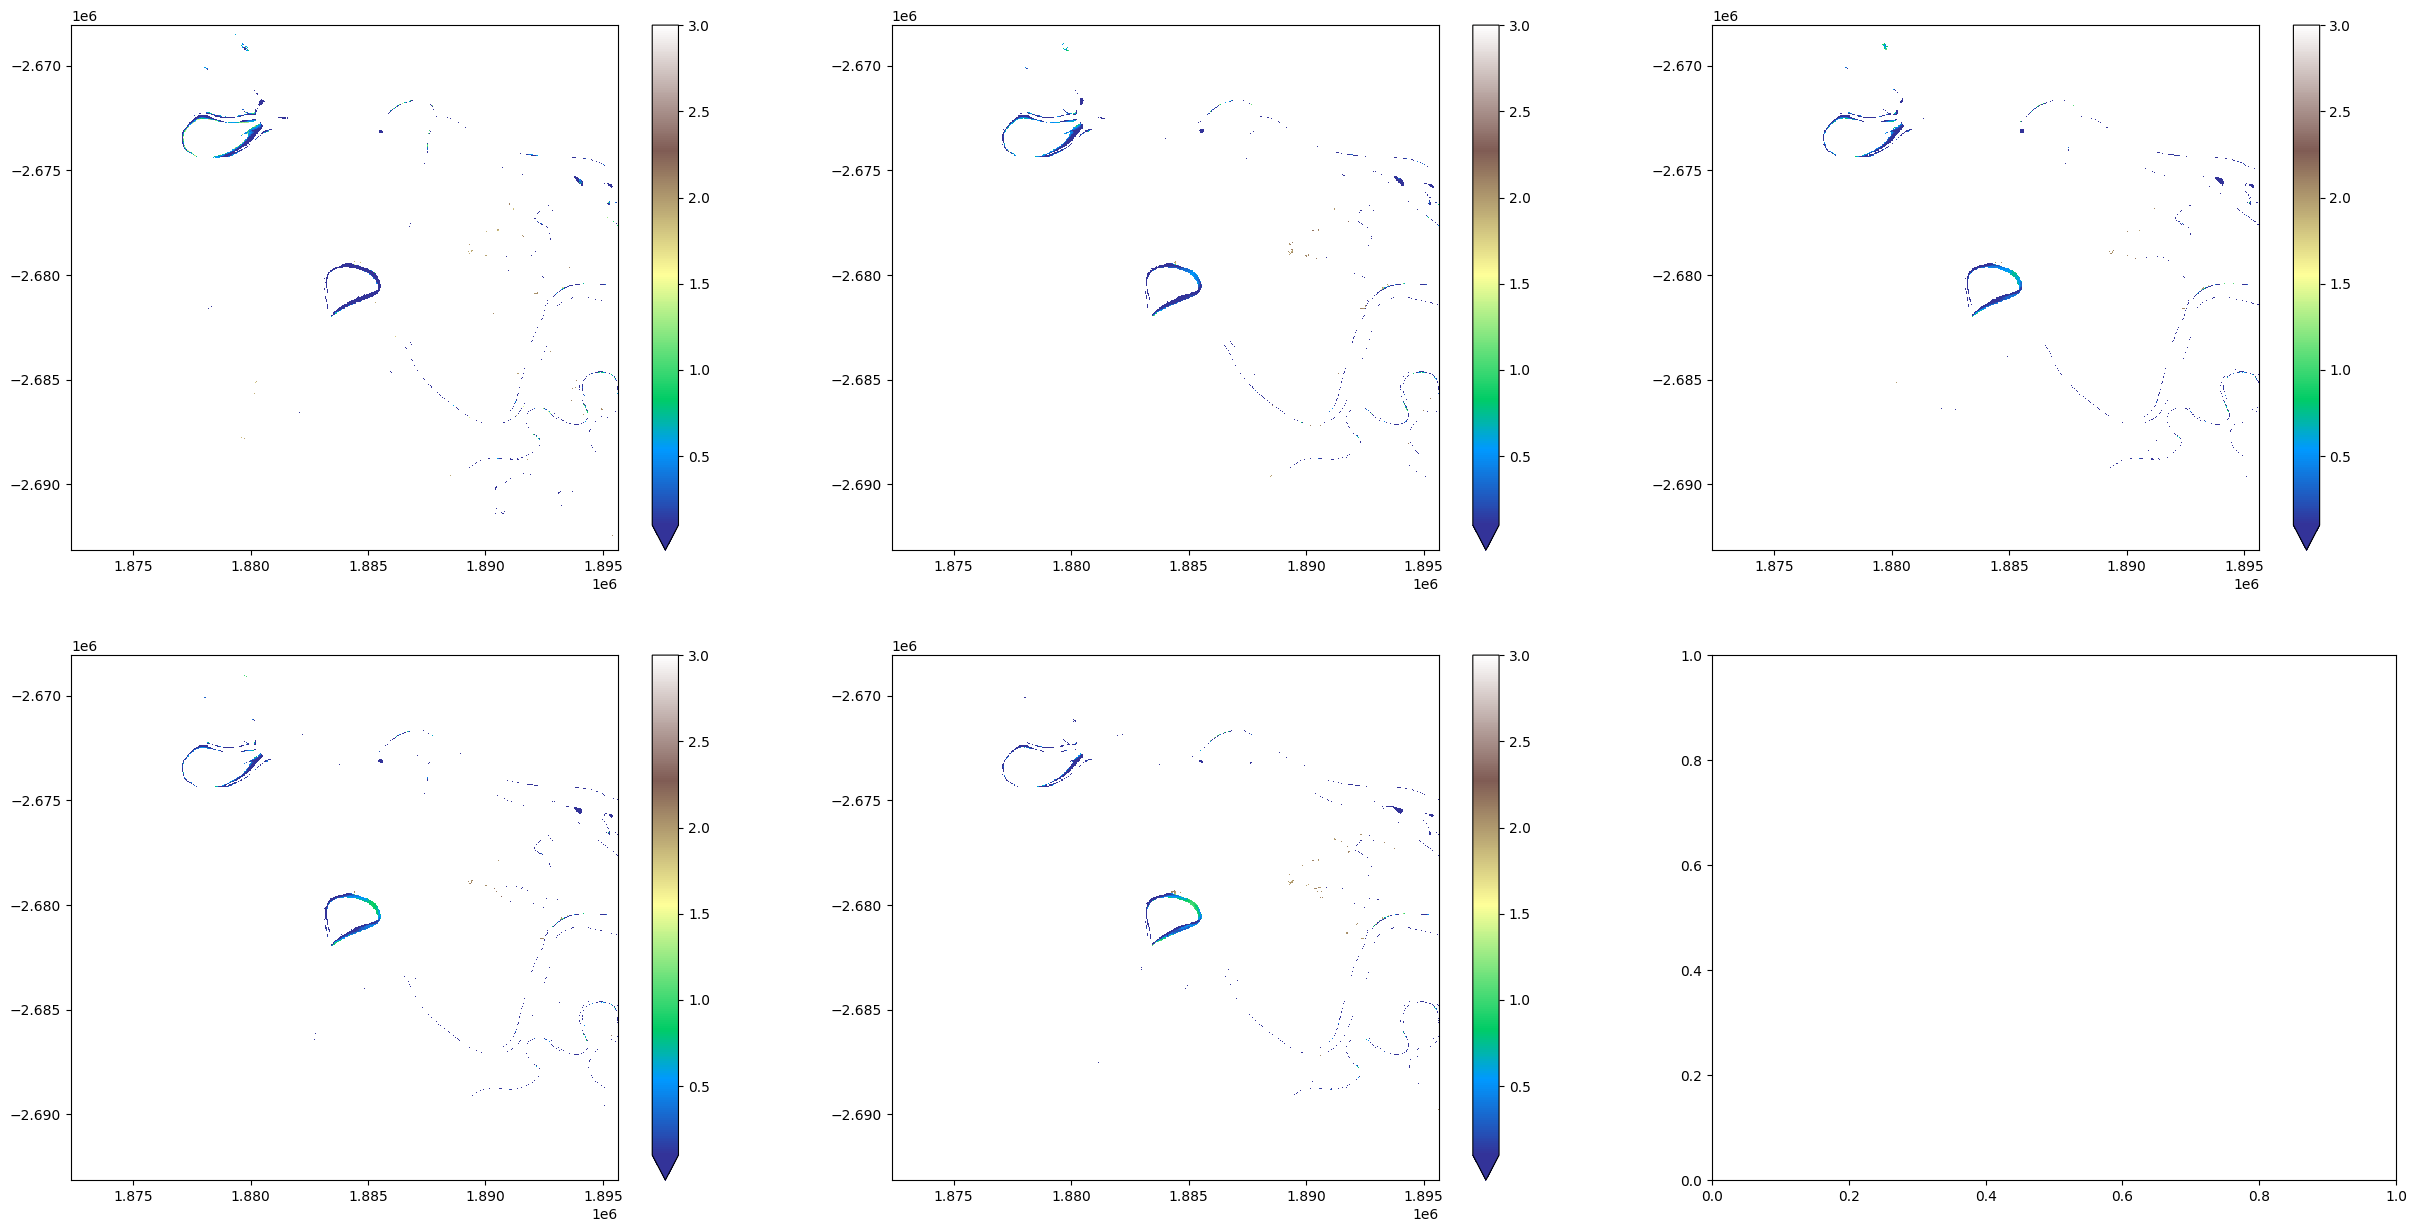

In [10]:
items_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 15))
items.elevation[0].plot(ax=axs[0,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
items.elevation[1].plot(ax=axs[0,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
items.elevation[2].plot(ax=axs[0,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
items.elevation[3].plot(ax=axs[1,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
items.elevation[4].plot(ax=axs[1,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
items.elevation[5].plot(ax=axs[1,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

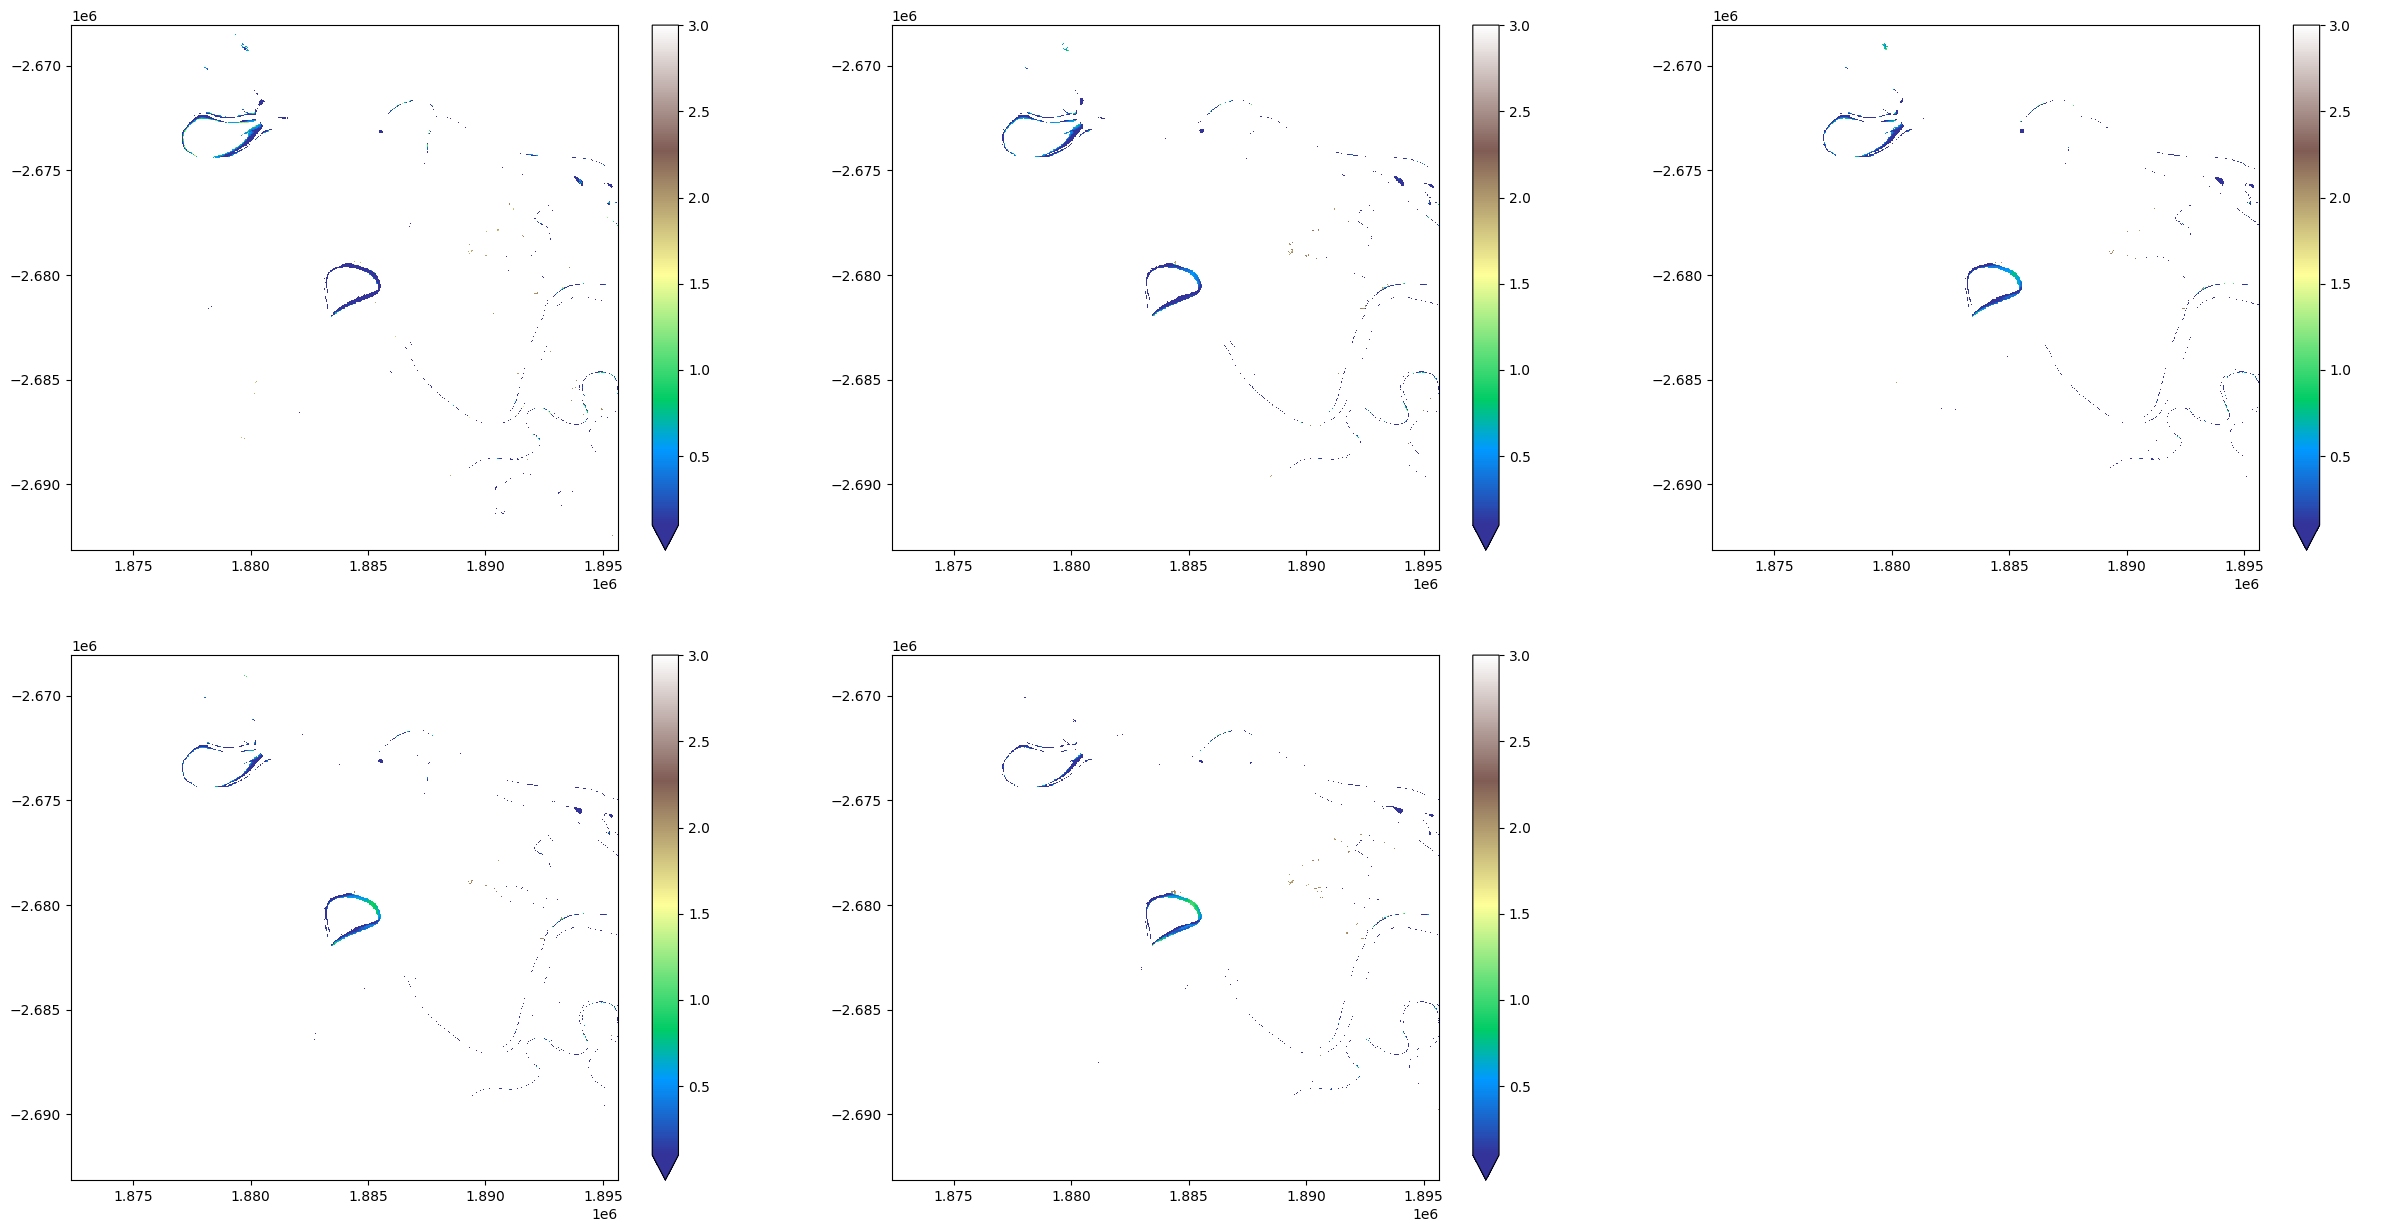

In [15]:
items_fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
axs = axs.flatten()

items.elevation[0].plot(ax=axs[0], vmin=0.1, vmax=3, add_labels=False, cmap='terrain')
items.elevation[1].plot(ax=axs[1], vmin=0.1, vmax=3, add_labels=False, cmap='terrain')
items.elevation[2].plot(ax=axs[2], vmin=0.1, vmax=3, add_labels=False, cmap='terrain')
items.elevation[3].plot(ax=axs[3], vmin=0.1, vmax=3, add_labels=False, cmap='terrain')
items.elevation[4].plot(ax=axs[4], vmin=0.1, vmax=3, add_labels=False, cmap='terrain')

axs[5].axis('off')

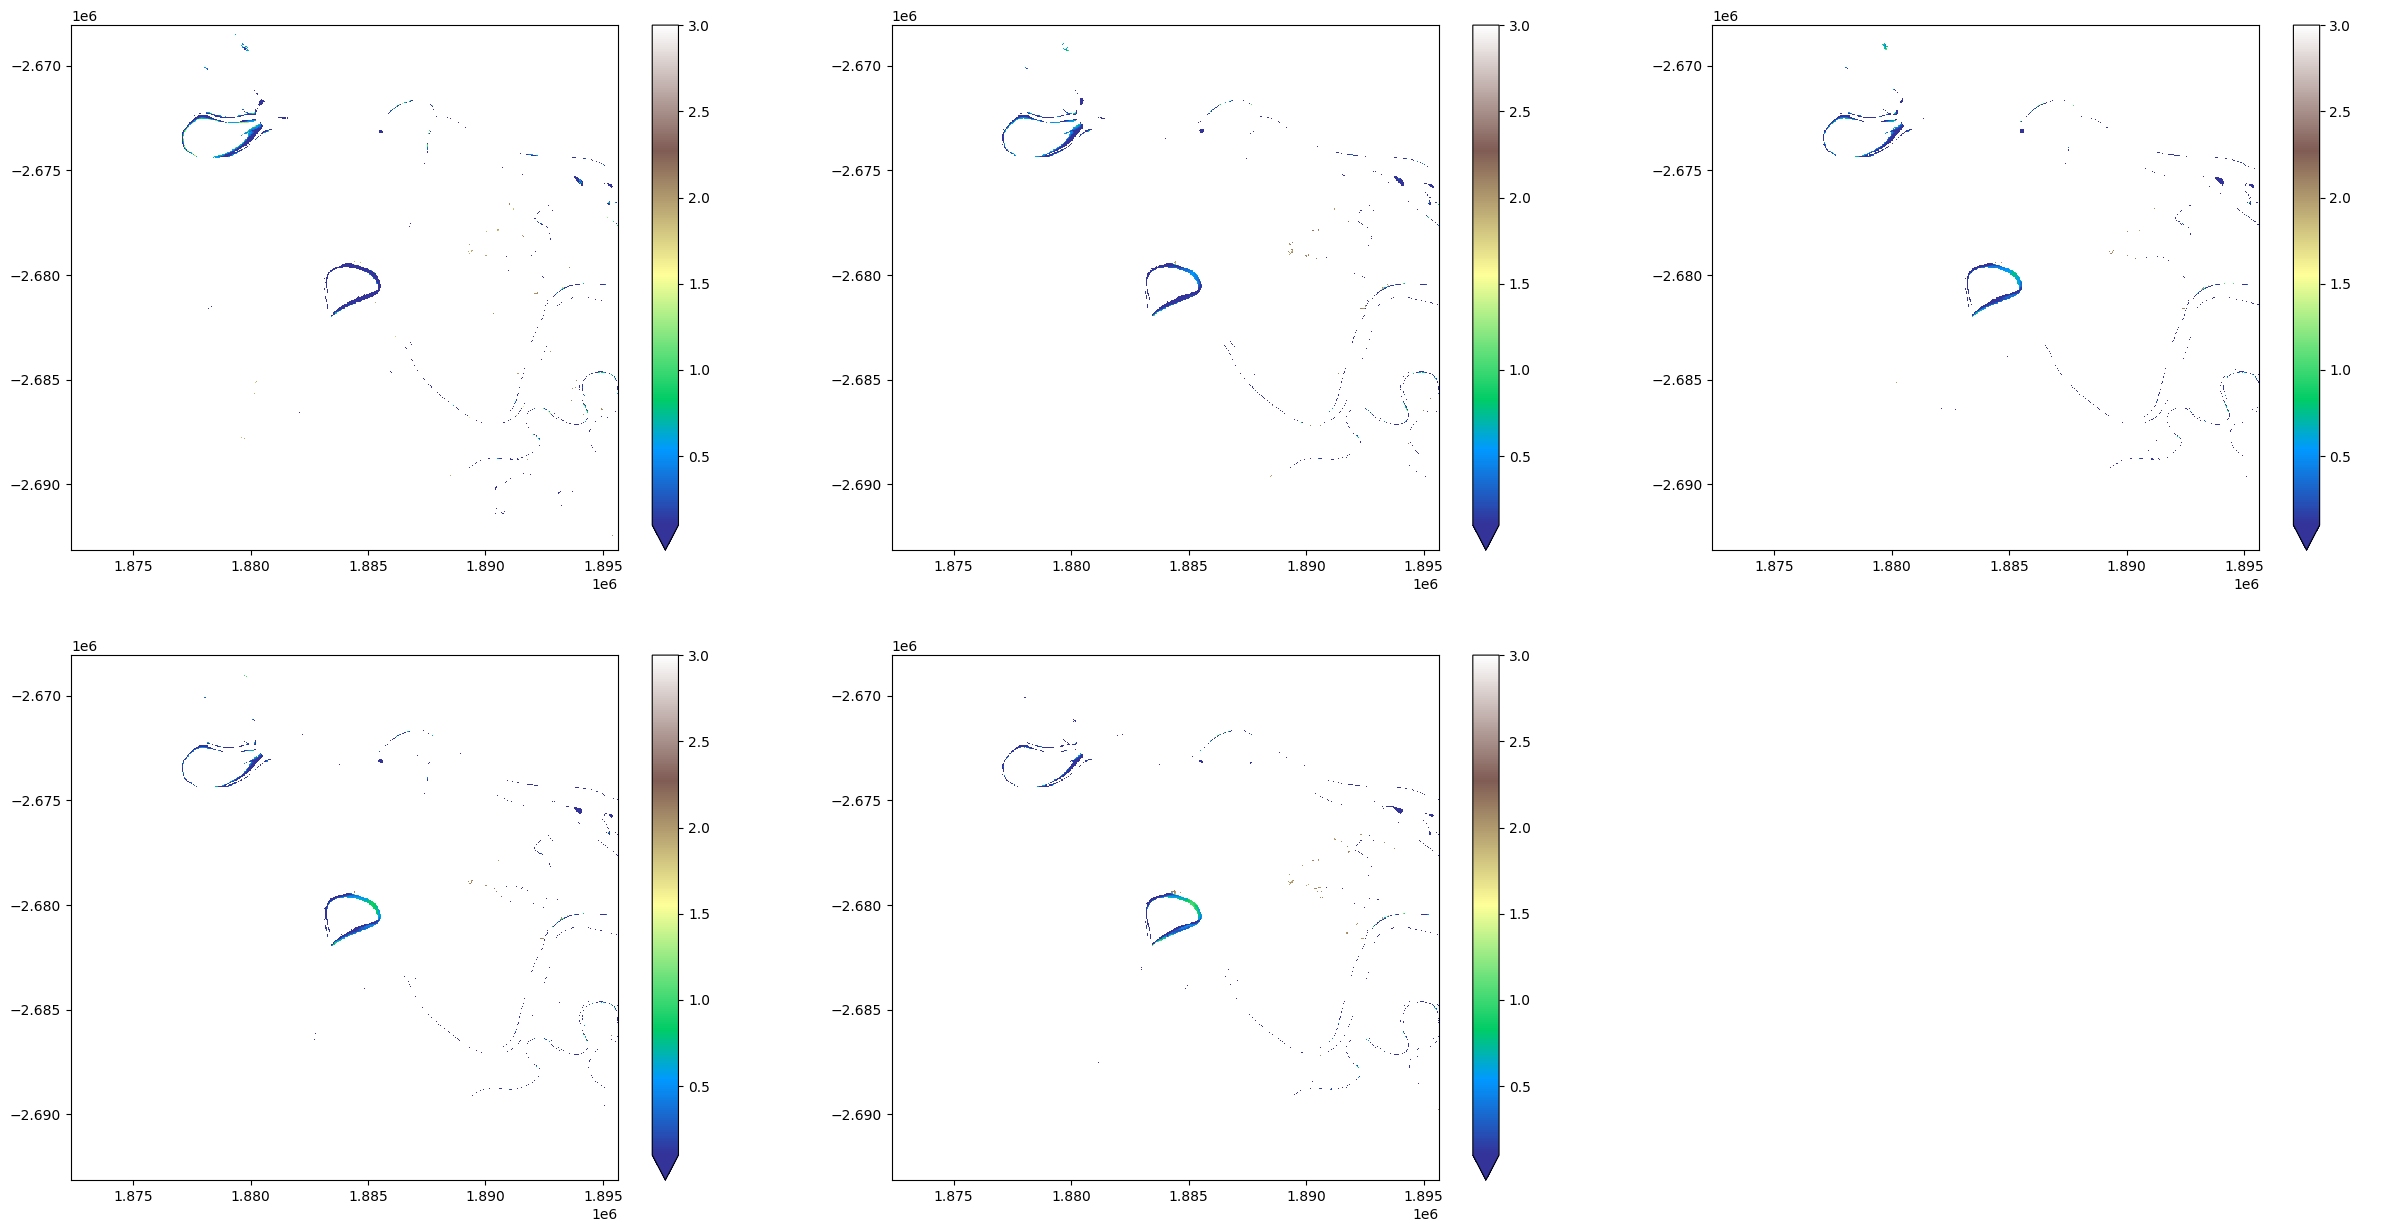

In [11]:
items_fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
axs = axs.flatten()  # make it 1D array of axes

for i, ax in enumerate(axs):
    if i < items.elevation.shape[0]:  # only plot available slices
        items.elevation[i].plot(ax=ax, vmin=0.1, vmax=3, add_labels=False, cmap='terrain')
    else:
        ax.axis('off')

### Exploring the intertidal exposure
View the different exposures of the intertidal area. 

DEA's Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on the Ensemble Tidal Modelling approach. Exposure percentage is calculated as the fraction of exposed observations relative to the total number of observations generated in the high temporal resolution tidal model for the 3-year product epoch.

**Note:** You can change the range of the display using vmin and vmax and also the colour map [(cmap)](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

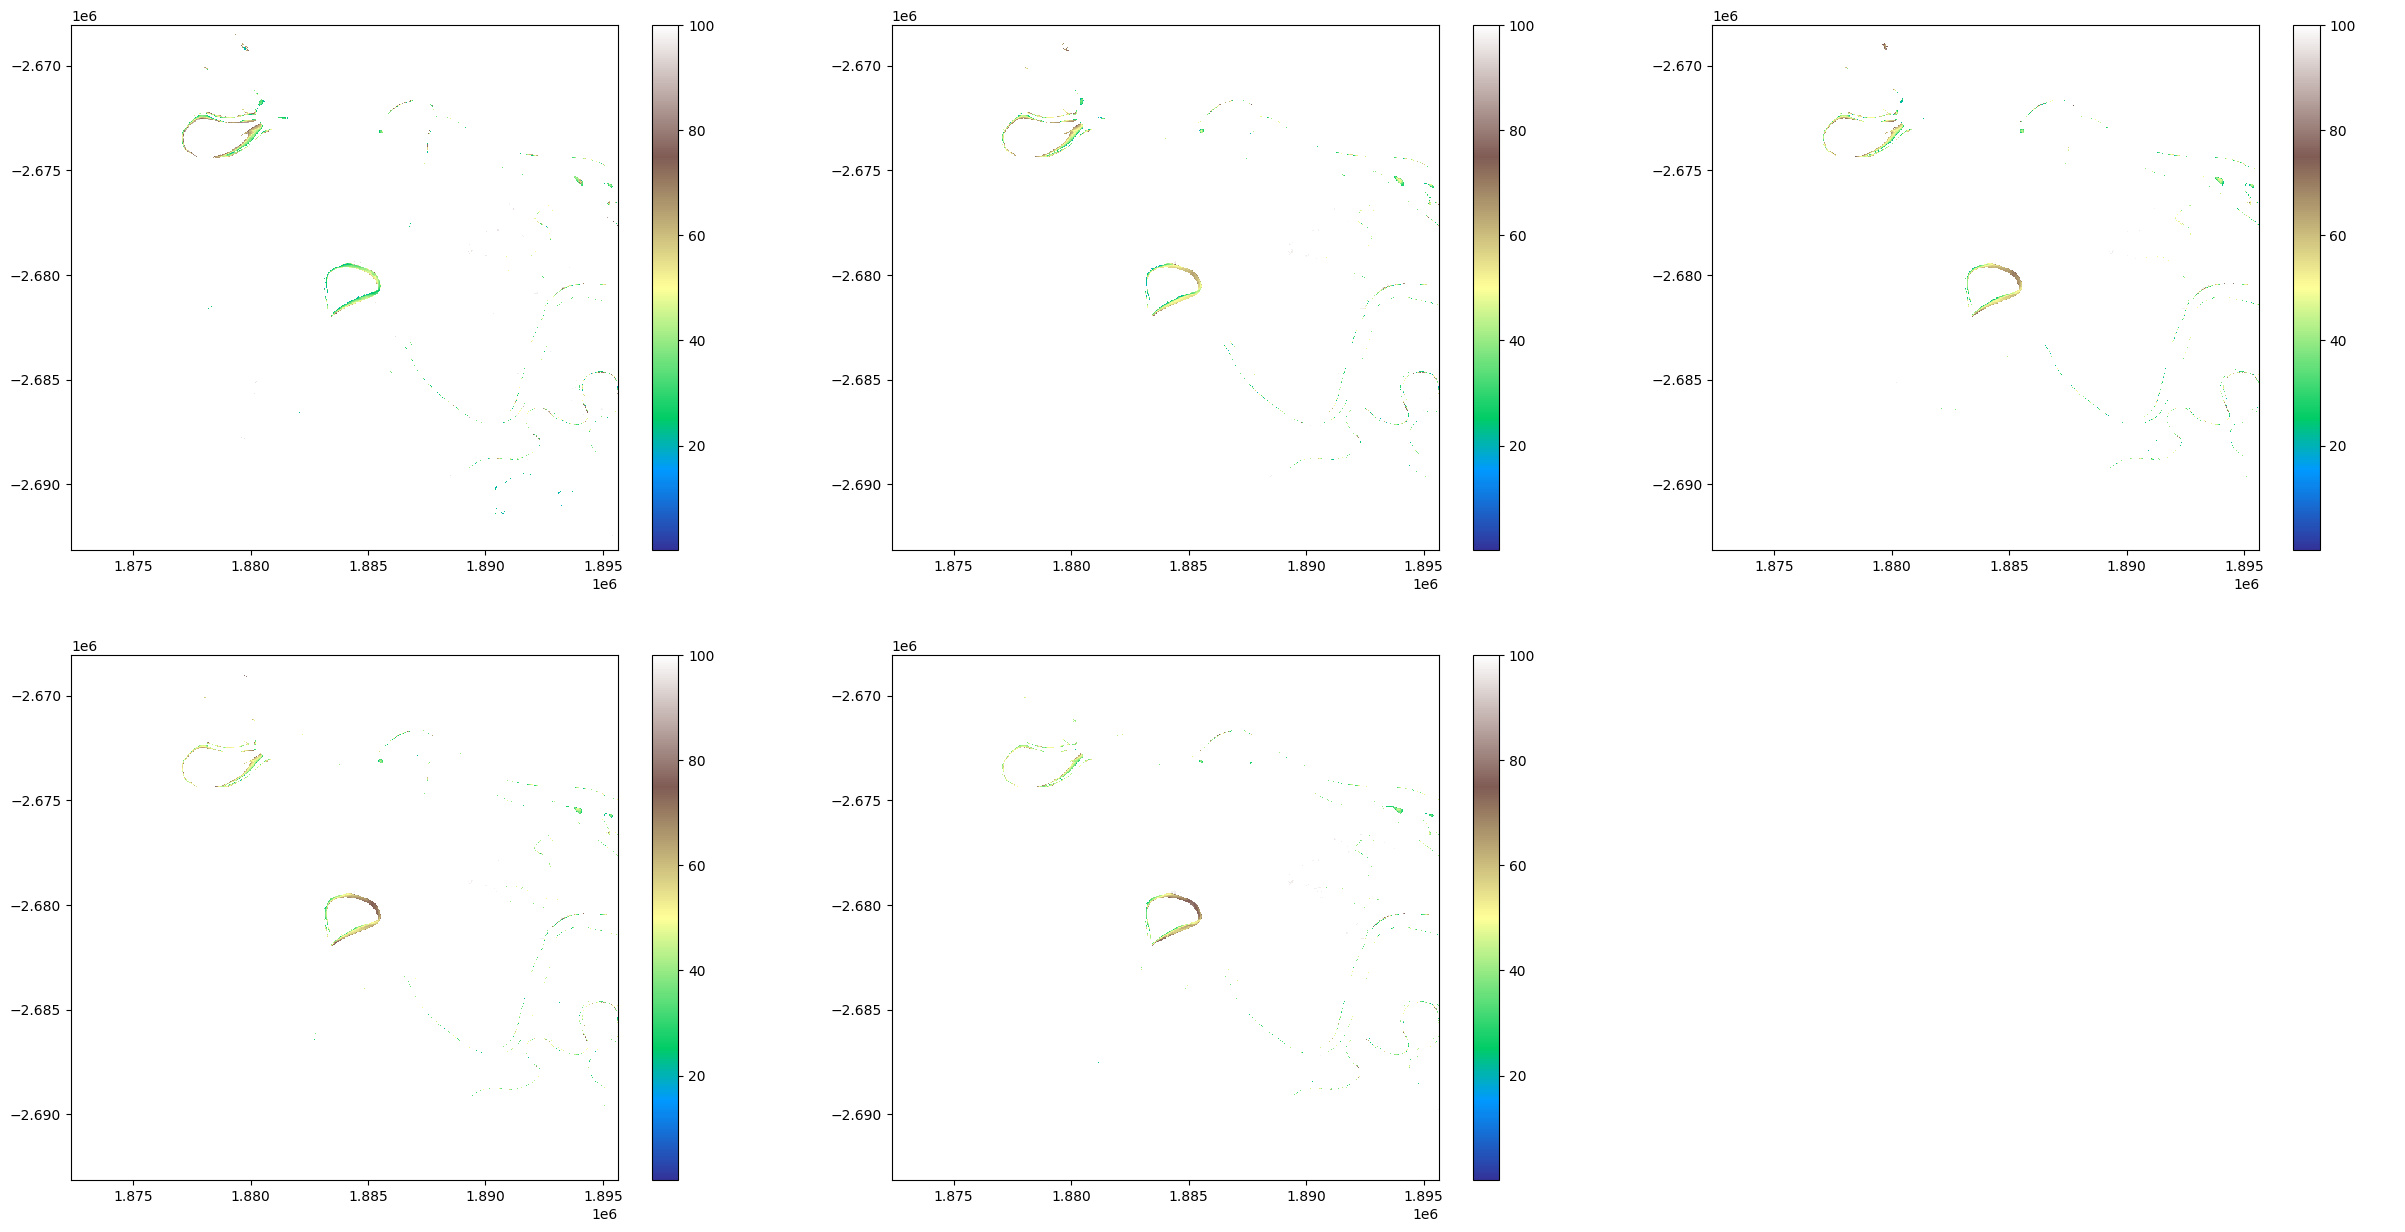

In [14]:
items_fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
axs = axs.flatten()  # make it 1D array of axes

for i, ax in enumerate(axs):
    if i < items.exposure.shape[0]:  # only plot available slices
        items.exposure[i].plot(ax=ax, vmin=0.1, vmax=100, add_labels=False, cmap='terrain')
    else:
        ax.axis('off')

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`